In [1]:
from pylab import *
%matplotlib inline

# Loading Data

In [2]:
!gunzip -v ../data/K562_2000_merged_histones_init.csv.gz -c > ../data/K562_2000_merged_histones_init.csv

../data/K562_2000_merged_histones_init.csv.gz:	 76.4%


In [2]:
import pandas as pd
from repli1d.nn import load_signal,transform_norm,train_test_split,transform_seq
name="../data/K562_2000_merged_histones_init.csv"
marks = [ "H3K4me1", "H3K4me3", "H3K27me3", "H3K36me3",
                         "H3K9me3","H2A.Z","H3K79me2","H3K9ac","H3K4me2","H3K27ac","H4K20me1"]
df, yinit, notnan = load_signal(name,
                                marks=marks,
                                targets=["initiation"],
                                 t_norm=transform_norm, smm=5,wig=False)
XC = pd.read_csv(name)  # List of chromosome coordinates
traint = ["chr%i"%i for i in [3,4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] +[20, 21, 22, 23]]
testv= ["chr1"]
train, test = train_test_split(XC, traint, testv, notnan)
#X_train_us, y_train_us = df , yinit
X_train_us, X_test_us, y_train_us, y_test_us = df[train], df[test], yinit[train], yinit[test]

window=101
vtrain = transform_seq(X_train_us, y_train_us, 1, window)
vtest= transform_seq(X_test_us, y_test_us, 1, window)

#print(vtrain[0].shape,vtrain[1].shape)

You may need to install pyBigWig
         initiation       H3K4me1       H3K4me3      H3K27me3      H3K36me3  \
count  1.440505e+06  1.440505e+06  1.440505e+06  1.440505e+06  1.440505e+06   
mean   9.976736e-01  1.743105e+01  1.385608e+01  1.262667e+01  1.386203e+01   
std    2.943455e+00  3.547314e+01  4.096911e+01  1.356939e+01  1.990559e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.033000e-01  4.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00   
50%    2.160000e-01  7.000000e+00  8.000000e+00  9.000000e+00  8.000000e+00   
75%    5.352000e-01  1.500000e+01  1.200000e+01  1.600000e+01  1.400000e+01   
max    5.712940e+01  1.657000e+03  2.353000e+03  1.562000e+03  1.576000e+03   

            H3K9me3         H2A.Z      H3K79me2        H3K9ac       H3K4me2  \
count  1.440505e+06  1.440505e+06  1.440505e+06  1.440505e+06  1.440505e+06   
mean   2.009775e+01  2.315037e+01  2.184659e+01  1.761894e+01  1.295846e+01   
std    1.492397e+0

# Loading the network
command line to train it:
```
python src/repli1d/nn.py  --noenrichment --targets initiation --root training_dir/nn_K562_2000/ --listfile data/K562_2000_merged_histones_init.csv  --window 101 --wig 0 --predict_files data/K562_2000_merged_histones_init.csv --marks H3K4me1 H3K4me3 H3K27me3 H3K36me3 H3K9me3 H2A.Z H3K79me2 H3K9ac H3K4me2 H3K27ac H4K20me1 --datafile```

In [3]:
import keras

model = keras.models.load_model("../data/nn_K562_2000_correct_split_Noneweights.04-0.0677.hdf5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 92, 15)         1665      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 92, 15)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 92, 15)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 83, 15)         2265      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 83, 15)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 83, 15)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 74, 15)        

In [6]:
vtrain[0].shape

(1440405, 1, 101, 11)

In [11]:
!head ../../jax_based_agent/notebooks/min_max_outputs.csv

,0
minimum,0.0
maximum,57.1294


In [6]:
#for batch in range(len(vtrain[0]))


In [4]:
from repli1d.nn import inv_transform
def binary_cross_entropy(true,pred):
    return -np.mean(true*np.log(pred+1e-7) + (1-true)*np.log(1-pred+1e-7))

which=["train:","test:"]
for i,ds in enumerate([vtrain,vtest]):
    #print(len(ds[0]))
    n=None
    data_start = model.predict(ds[0][:n])

    f=57.1294
    #f=1
    print(f"{which[i]}")
    print("MSE",np.mean((f*data_start-f*ds[1][:n])**2))
    print("Binary loss",binary_cross_entropy(ds[1][:n],data_start))

train:
MSE 2.7268503
Binary loss 0.06732607
test:
MSE 3.7287977
Binary loss 0.06988076


4.2921743


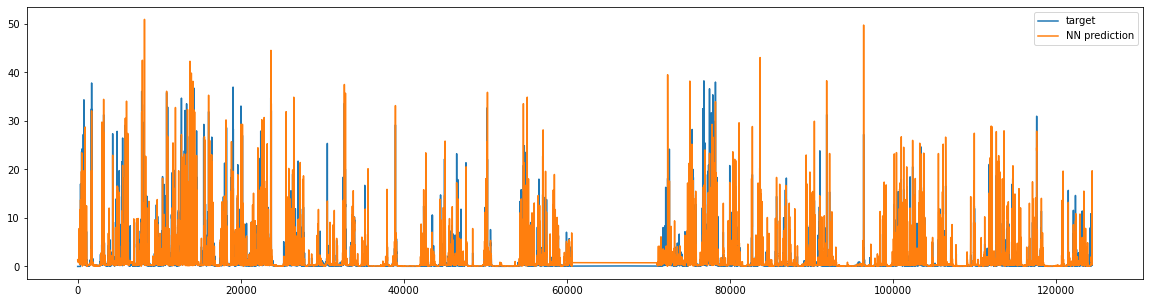

In [16]:
f=57.1294;
s=60000
figure(figsize=(20,5))
plot(ds[1][100:]*f,label="target")
plot(data_start[100:]*f,label="NN prediction")
print(np.mean((f*data_start[:s]-f*ds[1][:s])**2))

legend()

Text(0.5, 0, 'Genomic pos / 2000kb')

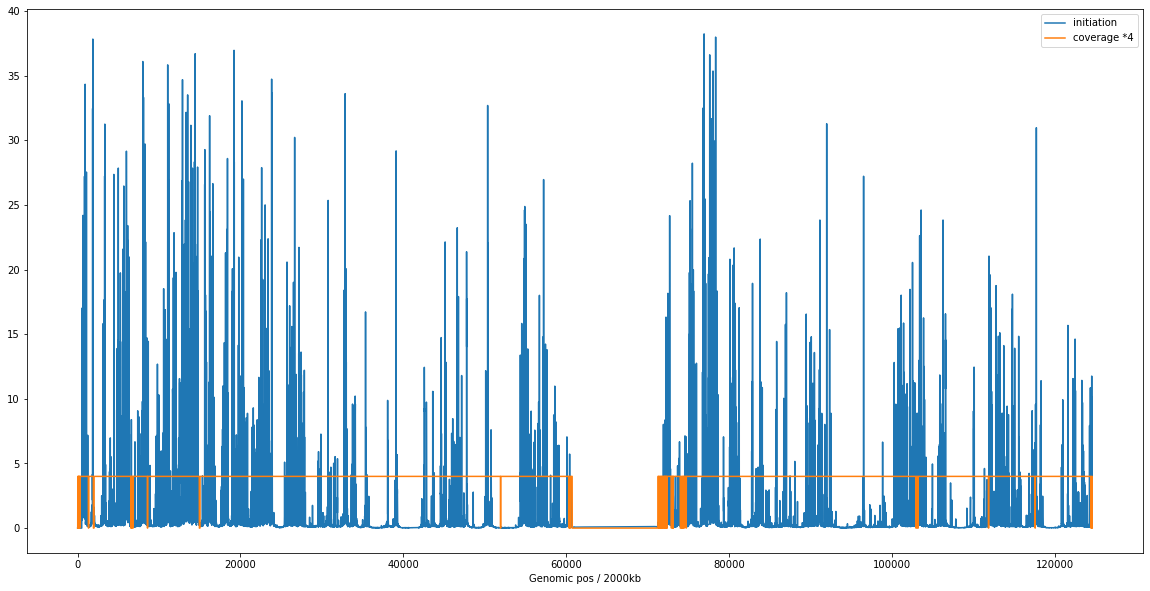

In [9]:
figure(figsize=(20,10))
cov = pd.read_csv("../data/hg19_2000_coverage.csv")
data = pd.read_csv("../data/K562_2000_merged_histones_init.csv")
plot(data[data.chrom=="chr1"].initiation,label="initiation")
plot(cov[cov.chrom=="chr1"].signal*4,label="coverage *4")
legend()
xlabel("Genomic pos / 2000kb")


In [11]:
len(data),len(cov)

(1440505, 1440505)

In [13]:
len(cov[cov.signal==0]) 

98465